In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np

In [3]:
# Eron Spam Classification Dataset

!wget https://www.dropbox.com/s/qvxz4qnyfb8w3re/train%20test%20data.csv?dl=0

--2020-04-19 13:11:11--  https://www.dropbox.com/s/qvxz4qnyfb8w3re/train%20test%20data.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qvxz4qnyfb8w3re/train%20test%20data.csv [following]
--2020-04-19 13:11:11--  https://www.dropbox.com/s/raw/qvxz4qnyfb8w3re/train%20test%20data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca4cb559d14ec690ce95fb79a6b.dl.dropboxusercontent.com/cd/0/inline/A2JVwoFUr0YRwdaBFwZ-AmIJpBEXDCCMWiDB9KHQ7RchPtVJxqjRBrzVTAYlZkkqzl6oQNSNGwtQ6s5BP5dnmUGf8EnZ2BtfFxZQjk4x85B6lS8npWaBUd6Gpw4qz-65LSU/file# [following]
--2020-04-19 13:11:12--  https://uca4cb559d14ec690ce95fb79a6b.dl.dropboxusercontent.com/cd/0/inline/A2JVwoFUr0YRwdaBFwZ-AmIJpBEXDCCMWiDB9KHQ7RchPtVJxqjRBrzVTAYlZkkqzl6oQNSNG

In [0]:
data=pd.read_csv(r'/content/train test data.csv?dl=0')

In [0]:
data=data[~data['Body'].isnull()]


In [51]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
lemma = WordNetLemmatizer()
my_stop=set(stopwords.words('english')+list(punctuation))

from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
data['concate']=data[['Subject','Body']].apply(lambda x:' '.join(x.astype(str)),axis=1)
df=data.loc[:,['concate','Class']]

In [0]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=2)

In [0]:
y_train=(df_train['Class']=='spam').astype(int)
y_train.reset_index(inplace=True,drop=True)
y_test=(df_test['Class']=='spam').astype(int)
y_test.reset_index(inplace=True,drop=True)

In [0]:
df_train.reset_index(inplace=True,drop=True)
df_test.reset_index(inplace=True,drop=True)

In [0]:
my_stop=set(stopwords.words('english')+list(punctuation)+[i for i in '0123456789'])

In [0]:
def lemmatize(text):
    """ Tokenize text and lemmatize word tokens """
    
    text=text.lower()
    def get_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        return wordnet.NOUN
    
    wnl = WordNetLemmatizer()
    num=re.compile(u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    return [wnl.lemmatize(token, get_pos(tag)) for token, tag in pos_tag(word_tokenize(text)) if (token not in my_stop) and (num.search(token)!=None)]

tf=TfidfVectorizer(tokenizer=lemmatize ,min_df=100,max_df=500)

In [12]:
tf.fit(df_train['concate'])
train_tf=tf.transform(df_train['concate'])


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [0]:
x_train_tf=pd.DataFrame(train_tf.toarray(),columns=tf.get_feature_names())
col=x_train_tf.columns

In [34]:
print(x_train_tf.shape,y_train.shape)
print(x_test_tf.shape,y_test.shape)

input_len=x_train_tf.shape[1]
print(input_len,type(input_len))

(26600, 2219) (26600,)
(6651, 2219) (6651,)
2219 <class 'int'>


In [0]:
test_tf=tf.transform(df_test['concate'])
x_test_tf=pd.DataFrame(test_tf.toarray(),columns=tf.get_feature_names())

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, LSTM
from tensorflow.keras import backend as K

from tensorflow.keras.backend import sigmoid
from tensorflow.keras import activations

from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score

In [0]:
model = Sequential()

model.add(Dense(1000,input_dim=input_len,activation='relu'))

model.add(Dropout(0.1))

model.add(Dense(500,activation=LeakyReLU()))

model.add(Dropout(0.1))

model.add(Dense(200,activation='relu'))

model.add(Dropout(0.15))

model.add(Dense(50,activation=LeakyReLU()))

model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))

In [36]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              2220000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

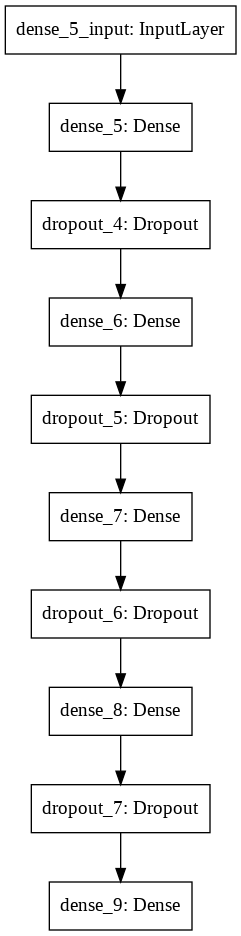

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [38]:
model.fit(x_train_tf,y_train.values,validation_data=(x_test_tf,y_test.values),epochs=100,batch_size=100,verbose=1)

Epoch 1/100
266/266 [==============================] - 1s 5ms/step - loss: 0.1559 - accuracy: 0.9325 - val_loss: 0.1147 - val_accuracy: 0.9505
Epoch 2/100
266/266 [==============================] - 1s 5ms/step - loss: 0.0640 - accuracy: 0.9731 - val_loss: 0.1095 - val_accuracy: 0.9549
Epoch 3/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0375 - accuracy: 0.9830 - val_loss: 0.1466 - val_accuracy: 0.9556
Epoch 4/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9866 - val_loss: 0.2415 - val_accuracy: 0.9553
Epoch 5/100
266/266 [==============================] - 1s 5ms/step - loss: 0.0255 - accuracy: 0.9868 - val_loss: 0.2009 - val_accuracy: 0.9562
Epoch 6/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0275 - accuracy: 0.9858 - val_loss: 0.2383 - val_accuracy: 0.9513
Epoch 7/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.9858 - val_loss: 0.2228 - val_accuracy: 0.9535

In [39]:
print('Train Data Accuracy',roc_auc_score(y_train,model.predict(x_train_tf)))

print('Test Data Accuracy',roc_auc_score(y_test,model.predict(x_test_tf)))

Train Data Accuracy 0.9995335688806198
Test Data Accuracy 0.9917166148486698


In [0]:
cutoffs=np.linspace(0.01,0.99,99)
real=y_train
prob_score=model.predict(x_train_tf)

In [0]:
KS_cut=[]
for cutoff in cutoffs:
  predicted=pd.Series([0]*len(y_train))
  predicted=(prob_score>cutoff).astype(int)
  df=pd.DataFrame(list(zip(y_train,predicted)),columns=["real","predicted"])
  TP=len(df[(df["real"]==1) & (df["predicted"]==1) ])
  FP=len(df[(df["real"]==0) & (df["predicted"]==1) ])
  TN=len(df[(df["real"]==0) & (df["predicted"]==0) ])
  FN=len(df[(df["real"]==1) & (df["predicted"]==0) ])
  P=TP+FN
  N=TN+FP
  KS=(TP/P)-(FP/N)
  KS_cut.append(KS)

cutoff_data=pd.DataFrame(list(zip(cutoffs,KS_cut)),columns=["cutoff","KS"])

KS_cutoff=cutoff_data[cutoff_data["KS"]==cutoff_data["KS"].max()]["cutoff"]

In [42]:
KS_cutoff

52    0.53
53    0.54
54    0.55
55    0.56
56    0.57
Name: cutoff, dtype: float64

In [43]:
y_predict_test=model.predict(x_test_tf)
binary_predict=((y_predict_test>0.53).astype(int))
y_data=pd.DataFrame(binary_predict,columns=['Predicted'])
y_data['Original']=y_test
pd.crosstab(y_data['Original'],y_data['Predicted'])

Predicted,0,1
Original,,
0,3148,99
1,193,3211


# Word Embedding

In [0]:
data_train,data_test=train_test_split(data,test_size=0.2,random_state=2)

data_train.reset_index(inplace=True,drop=True)
data_test.reset_index(inplace=True,drop=True)

x_train=data_train.loc[:,['Subject','Body']]
x_train.reset_index(inplace=True,drop=True)

x_test=data_test.loc[:,['Subject','Body']]
x_test.reset_index(inplace=True,drop=True)

In [0]:
sen_len=[]

for sent in data['Body']:
  sen_len.append(len(word_tokenize(sent)))

In [46]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

!unzip /content/glove.840B.300d.zip

--2020-04-19 14:40:23--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-04-19 14:40:23--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-04-19 14:40:24--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [0]:
embedding_index={}

f=open('glove.840B.300d.txt','r',errors='ignore',encoding='utf8')

for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[-300:],dtype='float32')
  embedding_index[word]=coefs
f.close()

In [52]:
# Subject word embedding on train and test data

max_len_sub = 15
tok_sub = Tokenizer(char_level=False,split=' ')
tok_sub.fit_on_texts(data_train['Subject'])

vocab_len_sub=len(tok_sub.word_index)
print("vocab_len_sub :",vocab_len_sub)

sequence_sub=tok_sub.texts_to_sequences(data_train['Subject'])
sequence_matrix_sub=sequence.pad_sequences(sequence_sub,maxlen=max_len_sub)

embedding_matrix_sub=np.zeros((vocab_len_sub+1,300))

for word,i in tok_sub.word_index.items():
  embed_vector=embedding_index.get(word)
  if embed_vector is not None:
    embedding_matrix_sub[i]=embed_vector

sequence_sub_test=tok_sub.texts_to_sequences(data_test['Subject'])
sequence_matrix_sub_test=sequence.pad_sequences(sequence_sub_test,maxlen=max_len_sub)

vocab_len_sub : 15989


In [53]:
# Body Word embedding on train and test data

max_len_body=900
tok_body=Tokenizer()
tok_body.fit_on_texts(data_train['Body'])

sequence_body=tok_body.texts_to_sequences(data_train['Body'])
sequence_matrix_body=sequence.pad_sequences(sequence_body,max_len_body)

vocab_len_body=len(tok_body.word_index)
print("vocab_len_body :",vocab_len_body)

embedding_matrix_body=np.zeros((vocab_len_body+1,300))

for word,i in tok_body.word_index.items():
  embed_vector=embedding_index.get(word)
  if embed_vector is not None:
    embedding_matrix_body[i]=embed_vector

sequence_body_test=tok_body.texts_to_sequences(data_test['Body'])
sequence_matrix_body_test=sequence.pad_sequences(sequence_body_test,maxlen=max_len_body)



vocab_len_body : 135962


In [0]:
from tensorflow.keras.layers import Dense,LSTM, BatchNormalization, Dropout,concatenate,Input,Embedding
from tensorflow.keras.models import Model

In [0]:
### subject lstm 

input_sub=Input(name='input_sub',shape=[max_len_sub])

layer_sub = Embedding(vocab_len_sub+1,300,input_length=max_len_sub,mask_zero=True,weights=[embedding_matrix_sub],
                      trainable=False)(input_sub)
layer_sub = LSTM(64)(layer_sub)


In [0]:
### body lstm 

input_body=Input(name='input_body',shape=[max_len_body])

layer_body = Embedding(vocab_len_body+1,300,input_length=max_len_body,mask_zero=True,
                       weights=[embedding_matrix_body],trainable=False)(input_body)
layer_body = LSTM(64)(layer_body)

In [0]:
# conatenate and dense on top
x = concatenate([layer_sub, layer_body])

dense1 = Dense(100, activation='relu')(x)
dense2 = Dense(50, activation=LeakyReLU())(dense1)
drop1=Dropout(0.2)(dense2)
dense3=Dense(20,activation='relu')(drop1)
output = Dense(1, activation='sigmoid',name='output')(dense3)

In [131]:
model_we = Model(inputs=[input_sub,input_body],outputs=[output])
model_we.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_we.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sub (InputLayer)          [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 900)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      4797000     input_sub[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 900, 300)     40788900    input_body[0][0]                 
____________________________________________________________________________________________

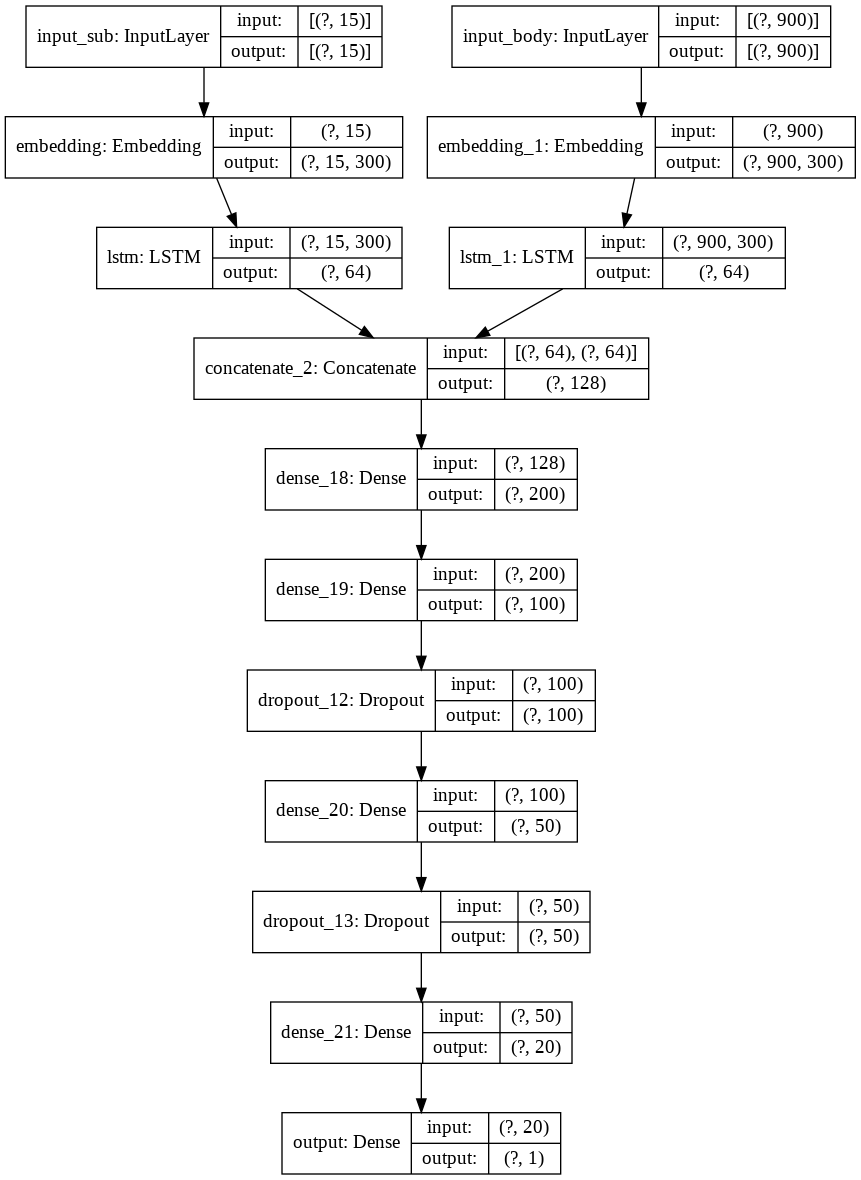

In [132]:
plot_model(model_we,show_shapes=True)

In [133]:
model_we.fit([sequence_matrix_sub,sequence_matrix_body],y_train.values,validation_data=([sequence_matrix_sub_test,sequence_matrix_body_test],y_test.values),
          epochs=6,batch_size=200,verbose=1)

Epoch 1/6
133/133 [==============================] - 108s 815ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0665 - val_accuracy: 0.9869
Epoch 3/6
133/133 [==============================] - 109s 817ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0542 - val_accuracy: 0.9850
Epoch 4/6
133/133 [==============================] - 109s 816ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0599 - val_accuracy: 0.9869
Epoch 5/6
133/133 [==============================] - 109s 823ms/step - loss: 5.4459e-04 - accuracy: 0.9999 - val_loss: 0.0745 - val_accuracy: 0.9869
Epoch 6/6
133/133 [==============================] - 110s 830ms/step - loss: 1.2965e-04 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 0.9880


In [134]:
print('Train data accuracy',roc_auc_score(y_train,model_we.predict([sequence_matrix_sub,sequence_matrix_body])))
print('Test data accuracy',roc_auc_score(y_test,model_we.predict([sequence_matrix_sub_test,sequence_matrix_body_test])))

Train data accuracy 1.0
Test data accuracy 0.9989506267558919


In [0]:
cutoffs=np.linspace(0.01,0.99,99)
real=y_train
prob_score=model_we.predict([sequence_matrix_sub,sequence_matrix_body])

In [0]:
KS_cut=[]
for cutoff in cutoffs:
  predicted=pd.Series([0]*len(y_train))
  predicted=(prob_score>cutoff).astype(int)
  df=pd.DataFrame(list(zip(y_train,predicted)),columns=["real","predicted"])
  TP=len(df[(df["real"]==1) & (df["predicted"]==1) ])
  FP=len(df[(df["real"]==0) & (df["predicted"]==1) ])
  TN=len(df[(df["real"]==0) & (df["predicted"]==0) ])
  FN=len(df[(df["real"]==1) & (df["predicted"]==0) ])
  P=TP+FN
  N=TN+FP
  KS=(TP/P)-(FP/N)
  KS_cut.append(KS)

cutoff_data=pd.DataFrame(list(zip(cutoffs,KS_cut)),columns=["cutoff","KS"])

KS_cutoff=cutoff_data[cutoff_data["KS"]==cutoff_data["KS"].max()]["cutoff"]

In [137]:
KS_cutoff

5     0.06
6     0.07
7     0.08
8     0.09
9     0.10
      ... 
69    0.70
70    0.71
71    0.72
72    0.73
73    0.74
Name: cutoff, Length: 69, dtype: float64

In [73]:
y_predict_test=model.predict(x_test_tf)
binary_predict=((y_predict_test>0.50).astype(int))
y_data=pd.DataFrame(binary_predict,columns=['Predicted'])
y_data['Original']=y_test
pd.crosstab(y_data['Original'],y_data['Predicted'])

Predicted,0,1
Original,,
0,3146,101
1,190,3214


In [0]:
spam_mail=pd.read_csv(r'/content/my mail spam.csv?dl=0')

In [0]:
spam=spam_mail.loc[:,['Subject', 'Body']]

In [0]:
spam['Body']=np.where(spam['Body'].isnull(),"nan",spam['Body'])

In [0]:
import re
string_check= re.compile(r'[@_:.;!#$%^&*()<>?/\|}{~]+-*')
spam['Subject'] = spam['Subject'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

spam['Body'] = spam['Body'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

In [0]:
sequence_spam_mail_sub=tok_sub.texts_to_sequences(spam['Subject'])
seq_spam_mail_sub_matrix=sequence.pad_sequences(sequence_spam_mail_sub,maxlen=max_len_sub)

sequence_spam_mail_body=tok_body.texts_to_sequences(spam['Body'])
seq_spam_mail_body_matrix=sequence.pad_sequences(sequence.pad_sequences(sequence_spam_mail_body,maxlen=max_len_body))

In [0]:
y_spam_mail=model_we.predict([seq_spam_mail_sub_matrix,seq_spam_mail_body_matrix])

In [0]:
y_spam_binary=pd.DataFrame((y_spam_mail>0.06).astype(int),columns=['y_spam_pred'])

In [142]:
y_spam_binary['y_spam_pred'].value_counts()

1    271
0     33
Name: y_spam_pred, dtype: int64

In [0]:
spam['predicted_we']=(y_spam_mail>0.06).astype(int)

In [ ]:
mydata=pd.read_csv(r'/content/my mail.csv?dl=0')

In [0]:
mail=mydata.loc[(mydata['Subject'].notnull()) & (mydata['Body'].notnull()),['Mail_Id','Subject','Body']]
mail.reset_index(drop=True,inplace=True)

In [0]:
string_check= re.compile(r'[@_:.;!#$%^&*()<>?/\|}{~]+-*')
mail['Subject'] = mail['Subject'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

mail['Body'] = mail['Body'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

In [0]:
# Mail Subject

sequence_mail_sub=tok_sub.texts_to_sequences(mail['Subject'])
sequence_mail_sub_matrix=sequence.pad_sequences(sequence_mail_sub,maxlen=max_len_sub)

# Mail Body

sequence_mail_body=tok_body.texts_to_sequences(mail['Body'])
sequence_mail_body_matrix=sequence.pad_sequences(sequence_mail_body,maxlen=max_len_body)

In [0]:
y_mail=model_we.predict([sequence_mail_sub_matrix,sequence_mail_body_matrix])

mail['predict_we']=(y_mail>0.06).astype(int)

In [148]:
mail['predict_we'].value_counts()

1    21005
0     3564
Name: predict_we, dtype: int64

In [0]:
# TF IDF Check

In [0]:
spam['concate']=spam[['Subject','Body']].apply(lambda x:' '.join(x.astype(str)),axis=1)

In [0]:
spam_tf=tf.transform(spam['concate'])
x_spam_tf=pd.DataFrame(spam_tf.toarray(),columns=tf.get_feature_names())

In [0]:
spam['predict_tf_idf']=(model.predict(x_spam_tf)>0.53).astype(int)

In [117]:
spam['predicted_we'].value_counts()

1    265
0     39
Name: predicted_we, dtype: int64

In [118]:
spam['predict_tf_idf'].value_counts()

1    200
0    104
Name: predict_tf_idf, dtype: int64

In [0]:
from google.colab import drive, files

In [85]:
drive.mount(r'/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

In [0]:
model.save(r'/content/gdrive/My Drive/model_tf.h5')

model_we.save(r'/content/gdrive/My Drive/model_we.h5')

In [0]:
import os

In [94]:
os.getcwd()

'/content'